## 1. Import Libraries

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import joblib

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

random_state = 4012

In [27]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import models
from keras import utils
from keras.layers import Input,Dense,LSTM,Dropout,Embedding,Bidirectional,concatenate
from keras.models import Model,Sequential
from keras.optimizers import SGD,Adam,RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

In [28]:
from scikeras.wrappers import KerasClassifier

## 2. Train Test Split

In [29]:
path = "../Raw Data Files/final_job_posting.csv"
df = pd.read_csv(path)
df.head()
# train test split
X = df.drop('fraudulent',axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state,stratify=y)

## 3. Model

In [30]:
# Combine them

scaler = StandardScaler()

onehot = OneHotEncoder(
    categories = [
            ['full time', 'contract', 'part time','flexi','other','unspecified'], # employment_type
            ['entry level', 'middle level', 'senior level', 'unspecified'], # required_experience
            ['high school or vocational degree', 'undergraduate', 'graduate', 'unspecified'], # required_education
    ],
    handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

freq_encoder = CountEncoder()

binary_columns = ['telecommuting', 'has_company_logo','has_questions', 'have_company_profile', 'have_requirements', 'have_benefits', 'have_category', 'high_salary']
numerical_columns = ['flesch_score_bin_ft','fk_grade_level_bin_ft', 'text_len']
onehot_columns = ['employment_type', 'required_experience','required_education']
freq_columns = ['location_country']
text_column = ['full_text']

preprocessor = ColumnTransformer([
    # (nickname, transformer to apply, columns to apply to)
    ('binary', 'passthrough', binary_columns),  # <- 'passthrough' says to keep them but don't apply anything
    ('numerical', scaler, numerical_columns),   
    ('onehot', onehot, onehot_columns),
    ('frequency',freq_encoder, freq_columns),
],  remainder='passthrough')


In [31]:
vocab_size=5000
sent_length=128
def text_process(df):
    onehot_repr=[one_hot(words,vocab_size)for words in df] 
    embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    return embedded_docs

def process_columns(df):
    if df is X_train:
        df_1 = df.drop('full_text',axis=1)
        df_1_prod = preprocessor.fit_transform(df_1)
        df_2 = df['full_text']
    else:
        df_1 = df.drop('full_text',axis=1)
        df_1_prod = preprocessor.transform(df_1)
        df_2 = df['full_text']
    
    text_index = text_process(df_2)
    return ([text_index, df_1_prod],df_1_prod.shape[1])


In [32]:
X_train_new,numeric_shape = process_columns(X_train)
X_test_new,numeric_shape = process_columns(X_test)

In [33]:
# define metrics
def recall_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true,y_pred):
  precision = precision_m(y_true,y_pred)
  recall = recall_m(y_true,y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
embedding_dim = 50
# text
text_input = Input(shape=(sent_length,), name='text_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
bidirectional_lstm = Bidirectional(LSTM(100))(embedding_layer)

# numeric
numeric_input = Input(shape=(numeric_shape,), name='numeric_input')

# merge the two inputs
merged = concatenate([bidirectional_lstm, numeric_input])

# 
#dense_layer = Dense(8, activation='relu')(merged)
dropout_layer = Dropout(0.3)(merged)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

BiLSTM_model = Model(inputs=[text_input, numeric_input], outputs=output_layer)

# 编译模型
BiLSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m])

# 打印模型结构
BiLSTM_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, 128, 50)              250000    ['text_input[0][0]']          
                                                                                                  
 bidirectional_15 (Bidirect  (None, 200)                  120800    ['embedding_15[0][0]']        
 ional)                                                                                           
                                                                                                  
 numeric_input (InputLayer)  [(None, 26)]                 0         []                     

In [50]:
BiLSTM_model.fit(X_train_new,y_train,validation_data=(X_test_new,y_test),epochs=5,batch_size=128)

Epoch 1/5
150/150 [==============================] - 209s 1s/step - loss: 6.6580 - f1_m: 0.3400 - val_loss: 0.0931 - val_f1_m: 0.7319
Epoch 2/5
150/150 [==============================] - 190s 1s/step - loss: 0.0787 - f1_m: 0.7813 - val_loss: 0.0711 - val_f1_m: 0.7734
Epoch 3/5
150/150 [==============================] - 191s 1s/step - loss: 0.0493 - f1_m: 0.8587 - val_loss: 0.0685 - val_f1_m: 0.8078
Epoch 4/5
150/150 [==============================] - 189s 1s/step - loss: 0.0296 - f1_m: 0.9207 - val_loss: 0.0681 - val_f1_m: 0.8085
Epoch 5/5
150/150 [==============================] - 187s 1s/step - loss: 0.0173 - f1_m: 0.9480 - val_loss: 0.0844 - val_f1_m: 0.7929


## 4. Evaluation

In [16]:
def evaluate(x_test,y_test,name,model):

    print(model,"\n")
    
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5).astype(int)

    scores = {}
    scores["Accuracy"]  = accuracy_score(y_test,y_pred).round(3)
    scores["Precision"] = precision_score(y_test,y_pred,average="weighted").round(3)
    scores["Recall"]    = recall_score(y_test,y_pred,average="weighted").round(3)
    scores["F1"]        = f1_score(y_test,y_pred,average="weighted").round(3)
    scores["ROC AUC"]   = roc_auc_score(y_test,y_pred,average="weighted").round(3)
    scores = {name:scores}
    print(pd.DataFrame(scores))

    cm = confusion_matrix(y_test,y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues_r')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')


150/150 [==============================] - 10s 61ms/step
           BiLSTM_model(with numeric features)
Accuracy                                 0.980
F1                                       0.978
Precision                                0.979
ROC AUC                                  0.853
Recall                                   0.980


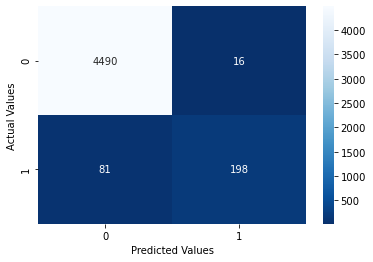

In [51]:
evaluate(X_test_new,y_test,'BiLSTM_model(with numeric features)',BiLSTM_model)